from time import time

start = time()# Hyperspectral Imaging

## Machine Learning and Computational Statistics, MSc in Data Science (2023/2024)
### Project Assignment

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

In [1]:
from time import time

start = time()

## Exploratory Analysis

We begin by importing the data. Our data is split in two files:

- `PaviaU_cube.mat`, which depicts the pixels for each image (300x200 resolution) for each of the 103 spectral bands

- `PaviaU_ground_truth.mat` which contains the class labels (materials) for each pixel in the image.

In [2]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt


pavia = sio.loadmat('data/PaviaU_cube.mat')
hsi = pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('data/PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends["endmembers"]

In [3]:
#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth = sio.loadmat('data/PaviaU_ground_truth.mat')
labels = ground_truth['y']
labels.shape

(300, 200)

Each of the 9 materials contains different values for each spectral band. We can see those values in the plot below:

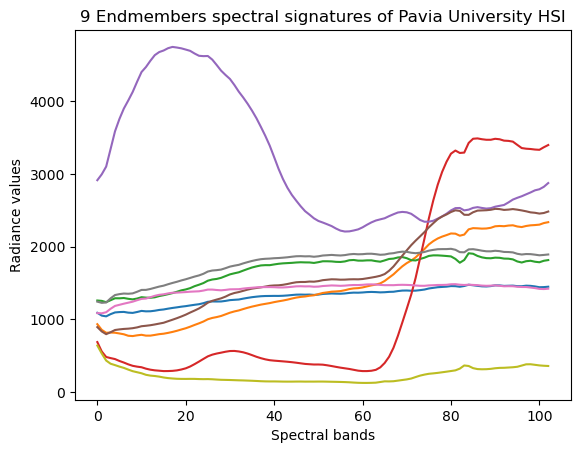

In [4]:
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

These 9 endmembers represent 9 classes of materials, which can be seen in the dictionary below:

In [5]:
class_names = {
    0: "Mixed",
    1: "Water",
    2: "Trees",
    3: "Asphalt",
    4: "Self-Blocking Bricks",
    5: "Bitumen",
    6: "Tiles",
    7: "Shadows",
    8: "Meadows",
    9: "Bare Soil"
}

For this analysis, we need to only keep pure pixels, aka pixels that corresponds to geographical areas with a single geological feature. We thus split our dataset into "classless" aka mixed pixels, and pixels with defined class labels (pure pixels).

In [6]:
mask = labels != 0
pure_hsi = np.where(mask[:,:, None], hsi, 0)

In [7]:
mask = labels == 0
mixed_hsi = np.where(mask[:,:, None] , hsi, 0)

Since our data represent an image we can also show the image for a specific spectral band

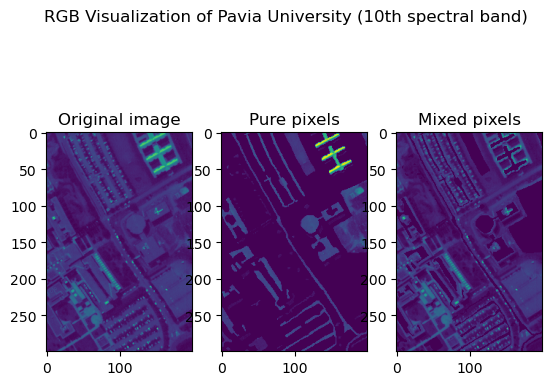

In [8]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(hsi[:,:,10])
axes[0].set_title("Original image")

axes[1].imshow(pure_hsi[:,:,10])
axes[1].set_title('Pure pixels')

axes[2].imshow(mixed_hsi[:,:,10])
axes[2].set_title('Mixed pixels')

fig.suptitle('RGB Visualization of Pavia University (10th spectral band)')
plt.show()

For demonstration purposes, let's select a pure pixel from the photograph. We select one of the pixels from the top right, from what looks like a building. This area of the photograph appears to have many continuous pure pixels, as seen by the Figure above.

In [9]:
focus_point = (32, 147)
print(f"Focus point is made of {class_names[labels[focus_point]]}")

Focus point is made of Bitumen


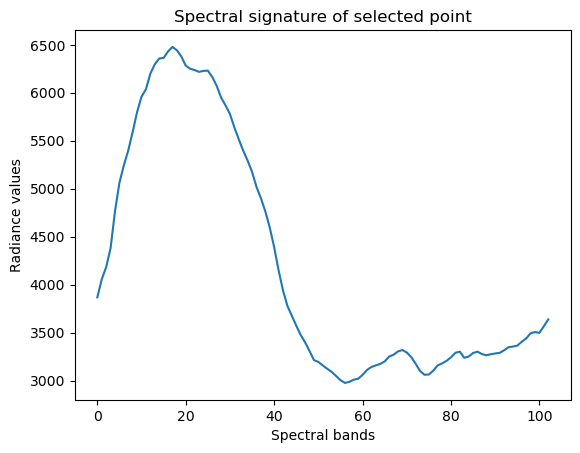

In [10]:
plt.plot(hsi[focus_point])
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title("Spectral signature of selected point")
plt.show()

Notice how similar this spectral signature is to the one defined in the graph above for pixels containing bitumen material.

## Spectral Unmixing

According to the *linear spectral unmixing hypothesis*, we can assume that every pixel ($y$) in our image is a linear combination of the various spectral signatures ($X$), where each spectral signature contributes a certrain percentage ($\theta$). Since all percentages must sum to one, this would make $\theta$ a *probability distribution function* (pdf), a property which would greately help in interpreting our results.

Under this assumption, the generating distribution for each pixel would be $y = X\theta + \eta, \eta \sim N(0, \sigma^2)$, where $\eta$ represents white noise. This model would be under the following constraints:
- No intercept (which would normally indicate a set % of an "other" material for all pixels)
- $\theta_i > 0, \forall i$
- $\sum_i \theta_i = 1$


We will be considering 4 models, each one following different constraints. Specifically, these will be:
1. An OLS model with no constraints
2. An OLS model with no intercept
3. An OLS model with no intercept and positive coefficients
4. An OLS model with no intercept and positive coefficients which sum to one
5. A LASSO model with no intercept and positive coefficients

Notice that out of the 5 models, only \#4 satisfies the prerequisitives of a pdf.

In [11]:
from prettytable import PrettyTable 


def arrays_stats(arrays: list[np.ndarray], names: list[str]|None = None, decimals: int = 2) -> PrettyTable:
    """
    Generate statistics for a list of NumPy arrays and create a PrettyTable.

    :param arrays: List of NumPy arrays for which statistics are calculated.
    :type arrays: list[np.ndarray]

    :param names: List of names corresponding to each array. If None, default names will be generated based on array indices. Default is None.
    :type names: list[str]|None

    :param decimals: Number of decimals to round the statistical values. Default is 2.
    :type decimals: int

    :return: Table containing statistics for each array, including mean, standard deviation, minimum, maximum, first quartile (Q1), and third quartile (Q3).
    :rtype: PrettyTable
    """
    stats_table = PrettyTable(["Array", "Shape", "Mean", "Std", "Min", "Max", "Q1", "Q3"])
    stats_table.float_format = "."+ str(decimals)

    if type(decimals) is not int:
        raise ValueError("The 'decimals' argument must be an integer.")

    if names is None:
        names = [i for i in range(len(arrays))]

    if len(names) != len(arrays):
        raise ValueError("Names and arrays must have the same length.")

    for name, array in zip(names, arrays):
        stats_table.add_row([name, array.shape, array.mean(),  array.std(),  
                             array.min(), array.max(), 
                             np.quantile(array, 0.25), np.quantile(array, 0.75)])
    return stats_table

In [12]:
# our analysis only concerns pure pixels
mask = labels != 0
y1 = pure_hsi.flatten()[pure_hsi[mask]].T
x1 = endmembers

y1.shape, x1.shape

((103, 12829), (103, 9))

In [13]:
arrays_stats([y1, x1], names=["y1", "x1"])

Array,Shape,Mean,Std,Min,Max,Q1,Q3
y1,"(103, 12829)",530.14,687.91,0,2266,0.00,1369.00
x1,"(103, 9)",1551.32,926.43,128.24,4745.65,1093.66,1897.79


We will also define some convinience functions to analyze the results of each model:

In [14]:
def reconstruction_error(y: np.ndarray, X: np.ndarray, 
                         abundance_map: np.ndarray) -> float:
    """
    Get the reconstruction error for the pure pixels in the image.
    Essentially a Mean Squares Error wrapper for the problem's domain.
    """
    theta = abundance_map
    return np.abs((y - X @ theta.T)).mean()

We will now define and run our models. We will then view and discuss the results in the next section.

### Ordinary Least Squares

In [15]:
from sklearn.linear_model import LinearRegression


base_model = LinearRegression(fit_intercept=True).fit(x1, y1)
base_abundance = base_model.coef_

In [16]:
base_error = reconstruction_error(y1, x1, base_abundance)
base_error

4023.7892601009435

### OLS no intercept, positive coefficients

In [17]:
pos_model = LinearRegression(fit_intercept=False, positive=True).fit(x1, y1)
pos_abundance = pos_model.coef_

In [18]:
pos_error = reconstruction_error(y1, x1, pos_abundance)
pos_error

313.8424774679923

### LASSO, no intercept, positive coefficients

In [19]:
from sklearn.linear_model import Lasso


lasso = Lasso(fit_intercept=False, positive=True, tol=1e-3, max_iter=int(1e5)).fit(x1, y1)
lasso_abundance = lasso.coef_

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


In [20]:
lasso_error = reconstruction_error(y1, x1, lasso_abundance)
lasso_error

313.806596700808

### OLS, no intercept, sum-to-one coefficients

In order to enforce the sum-to-one constraint we will build our own function using methods from the `scipy.optimize` module. While there are other solutions, these tend to either be very complicated and hard to modify for our needs (such as the `CVXOPT` package) or not work because of memory constraints / implementation bugs (in this case the `cvxpy` package).

Of note is that the current implementation needs to run a non-negative least squares and a coordinate descent with constraints routine for each one of our points, as the `nnls` function only supports vector calculations. This isn't as inefficient as it may sound, since the cost of the coordinate descent and non-negative least squares routines is proportionally much larger compared to the overhead of calling them for each point. 

Still, the calculation may take some minutes to complete. We could speed it up by assigning each point's calculations to different threads, as the calculation is independent between them. However, we choose to keep the single-threaded code for the sake of clarity and simplicity.

In [21]:
from tqdm import tqdm
from scipy.optimize import minimize 
from scipy.optimize import nnls 


def lsq_sum_to_one(A: np.ndarray, b: np.ndarray, 
                    bounds :list[list[float|None]], 
                    verbose: bool=True) -> np.ndarray:
    """
    Solve a least squares optimization problem subject to the constraint that the
    sum of the coefficients in each column of the solution matrix is equal to 1.

    Parameters:
    - A (np.ndarray): The coefficient matrix.
    - b (np.ndarray): The target values matrix.
    - bounds (List[List[Union[float, None]]]): Bounds on variables for optimization.
      Each inner list represents the bounds for a corresponding variable.
      A value of None indicates no bound in that direction.
    - verbose (bool, optional): If True, display progress using tqdm. Default is True.

    Returns:
    - np.ndarray: The solution matrix where each column satisfies the sum-to-one constraint.
    """

    coefficients = np.zeros((A.shape[1], b.shape[1]))

    # define minimization function
    min_func = lambda x, A, b: np.linalg.norm(A.dot(x) - b)

    #Define constraints and bounds
    cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}

    iterable = tqdm(range(y1.shape[1])) if verbose else range(y1.shape[1])

    for i in iterable:
        bi = b[:, i]
        #Use nnls to get initial guess
        x0, rnorm = nnls(A, bi)

        #Call minimisation subject to these values
        minout = minimize(min_func, x0, args=(A, bi), method='SLSQP', 
                          bounds=bounds,constraints=cons)
        x = minout.x
        coefficients[:, i] = x

    return coefficients

In [22]:
sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[None, None]]).T

100%|############################################################################| 12829/12829 [02:21<00:00, 90.92it/s]


Let's confirm that our results do indeed sum up to one:

In [23]:
sum1_coeffs.shape, np.isclose(sum1_coeffs.sum(axis=1), 1).sum()

((12829, 9), 12829)

In [24]:
sum1_abundance = sum1_coeffs
sum1_error = reconstruction_error(y1, x1, sum1_abundance)
sum1_error

175.08668894692306

### OLS, no intercept, positive and sum-to-one coefficients

In [25]:
pos_sum1_coeffs = lsq_sum_to_one(x1, y1, 9*[[0,None]]).T

100%|###########################################################################| 12829/12829 [00:58<00:00, 220.72it/s]


We can quickly check that our results satisfy the requirements of a pdf:

In [26]:
pos_sum1_coeffs.shape, np.isclose(pos_sum1_coeffs.sum(axis=1), 1, 1e-2).sum(), (pos_sum1_coeffs < 0).sum()

((12829, 9), 9381, 0)

There are a few rows which don't exactly add up to 1 (within $\pm 0.01$), which is expected since our algorithm is only approximate to our sum-to-one goal. Still, these deviations don't diverge as often or as enough for us to not count the resulting abundance map as a multi-dimensional pdf for each point.

In [27]:
pos_sum1_abundance = pos_sum1_coeffs
pos_sum1_error = reconstruction_error(y1, x1, pos_sum1_abundance)
pos_sum1_error

358.46645450959426

### Results

A table of the results for each model is presented below. Each row represents a different linear model, and the columns the reconstruction error, as well as the coefficients of the selected pixel we analyzed during the exploratory analysis.

In [28]:
def add_row(table, name, error, abundance, focus_point=0):
    res_table.add_row([name, error, abundance[focus_point][0], abundance[focus_point][1],
                      abundance[focus_point][2], abundance[focus_point][3], abundance[focus_point][4],
                      abundance[focus_point][5], abundance[focus_point][6], abundance[focus_point][7],
                      abundance[focus_point][8]])


abundance_dim = 9
res_table = PrettyTable(["Model", "Reconstruction Error"] + [f"x{i}" for i in range(1, abundance_dim+1)])
res_table.float_format = ".3"

add_row(res_table, "OLS", base_error, base_abundance)
add_row(res_table, "OLS pos", pos_error, pos_abundance)
add_row(res_table, "LASSO pos", lasso_error, lasso_abundance)
add_row(res_table, "OLS sum-to-1", sum1_error, sum1_abundance)
add_row(res_table, "OLS pos sum-to-1", pos_sum1_error, pos_sum1_abundance)

res_table

Model,Reconstruction Error,x1,x2,x3,x4,x5,x6,x7,x8,x9
OLS,4023.789,-50.413,9.482,-3.370,1.794,0.063,-10.707,3.672,31.568,5.981
OLS pos,313.842,0.000,0.000,0.000,0.268,0.000,0.000,0.000,0.000,0.000
LASSO pos,313.807,0.000,0.000,0.000,0.268,0.000,0.000,0.000,0.000,0.000
OLS sum-to-1,175.087,-41.842,7.105,5.302,1.403,0.034,-8.065,14.878,13.968,8.217
OLS pos sum-to-1,358.466,0.000,0.000,0.000,0.184,0.000,0.000,0.000,0.000,0.816


A number of observations can be made about our models:

1. The OLS model with no constraints does not lead to a good estimation.
1. The reconstruction error is lowest when we force the coefficients to sum to one, but not necessarily be positive.
1. The OLS with positive coefficients has almost identical results with the LASSO estimator, indicating our problem does not need any regularization. 
1. The OLS modeling a pdf (positive coefficients summing up to one) leads to a slightly larger error than the one without the positive constraint.

From these observations we conclude that:

The Linear Spectral Unmixing hypothesis seems to hold for our problem. This isn't surprising, since this hypothesis often holds and is widely used in practice `[1,2]`.

This conclusion is evident from the fact that our models generally become more efficient the more constraints we place on them, as well as from the fact that regularization appears uneccessary. This could be interpreted as selecting a very good prior for our regression problem, which effectively acts as an equivalent regualarization technique.

We can also trust that our pdf modeling approach is sufficient for our problem. We can thus use the estimates provided by our model to confidently model unmixed pixels in % terms of pure pixels.

`[1] Jiaojiao Wei, Xiaofei Wang, "An Overview on Linear Unmixing of Hyperspectral Data", Mathematical Problems in Engineering, vol. 2020, Article ID 3735403, 12 pages, 2020. https://doi.org/10.1155/2020/3735403`

`[2] Jan G.P.W. Clevers, Raul Zurita-Milla, 3 - Multisensor and multiresolution image fusion using the linear mixing model, Image Fusion, Academic Press, 2008, Pages 67-84, ISBN 9780123725295, https://doi.org/10.1016/B978-0-12-372529-5.00004-4 (https://www.sciencedirect.com/science/article/pii/B9780123725295000044)`

## Classification

We will attempt to classify pure pixels in the image. 

We will import the pixel labels. These represent the training, test and operational sets. The latter represents data we would normally acquire after having trained and tested our classifiers, and thus will not be used in this project. 

In [29]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('data/classification_labels_Pavia.mat')
y_train_set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
y_test_set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
y_oper_set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

arrays_stats([y_train_set, y_test_set, y_oper_set], names=["Train", "Test", "Operational"])

Array,Shape,Mean,Std,Min,Max,Q1,Q3
Train,"(300, 200)",0.54,1.76,0,9,0.00,0.00
Test,"(300, 200)",0.27,1.27,0,9,0.00,0.00
Operational,"(300, 200)",0.27,1.27,0,9,0.00,0.00


The label sets also act as masks, each containing only a subset of the original picture. We can use that to obtain the training, test and operation data from our original picture as follows:

In [30]:
mask = y_train_set != 0
x_train = hsi[mask]
y_train = y_train_set[mask].flatten()

x_train.shape, y_train.shape

((6415, 103), (6415,))

In [31]:
mask = y_test_set != 0
x_test = hsi[mask]
y_test = y_test_set[mask].flatten()

x_test.shape, y_test.shape

((3207, 103), (3207,))

In [32]:
mask = y_oper_set != 0
x_oper = hsi[mask]
y_oper = y_oper_set[mask].flatten()

x_oper.shape, y_oper.shape

((3207, 103), (3207,))

Notice how there is a 2:1 train to test ratio, which is atypical of most Machine Learning tasks (a 80%-20% split is much more widely accepted).

Since the labels and data still represent image pixels, we can clearly visualize the classes in our image:

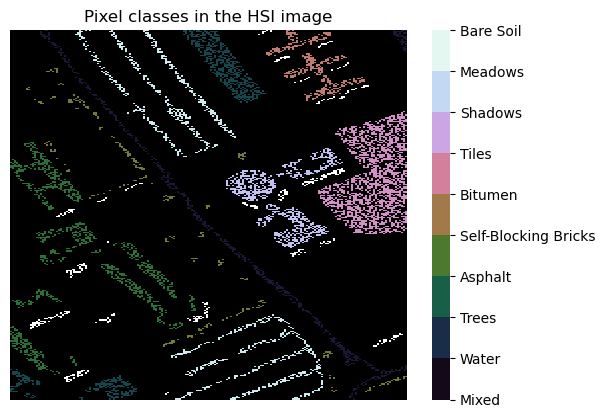

In [33]:
import seaborn as sns


ax = sns.heatmap(y_train_set.astype(int), 
                 cmap=sns.color_palette("cubehelix", as_cmap=True),
                 cbar_kws={"boundaries": np.arange(y_train_set.min(), y_train_set.max()+1, 1)})

ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(left=False, bottom=False)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(class_names.values())

plt.title("Pixel classes in the HSI image")
plt.show()

We will be considering the following estimators:

- Naive Bayes
- Minimum Euclidean Distance
- Bayesian Classifier
- K-Nearest Neighbours

Each model will be evaluated based on 10-K cross validation. We will then train the classifier with all available data to get the training accuracy and confusion matrix.

### Naive Bayes

In [34]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None):
    res = cross_val_score(model, x, y, cv=10, scoring=scoring)
    return res.mean(), res.std()

In [35]:
from sklearn.naive_bayes import GaussianNB


res = cross_val_res(GaussianNB(), x_train, y_train)
print(f"Naive Bayes mean accuracy {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean accuracy 0.6447, std: 0.0568


In [36]:
naive_model = GaussianNB().fit(x_train, y_train)
naive_train_res = naive_model.predict(x_train)
naive_test_res = naive_model.predict(x_test)

In [37]:
def confusion_matrix(true_labels, predicted_labels):
    """
    Construct the confusion matrix for a classifier.

    Parameters:
    - true_labels: numpy array of true labels
    - predicted_labels: numpy array of predicted labels
    - num_classes: number of classes in the classification problem (optional)

    Returns:
    - confusion_matrix: numpy array representing the confusion matrix
    """
    num_classes = max(np.max(true_labels), np.max(predicted_labels)) + 1

    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(true_labels, predicted_labels):
        confusion_matrix[true, pred] += 1

    return confusion_matrix

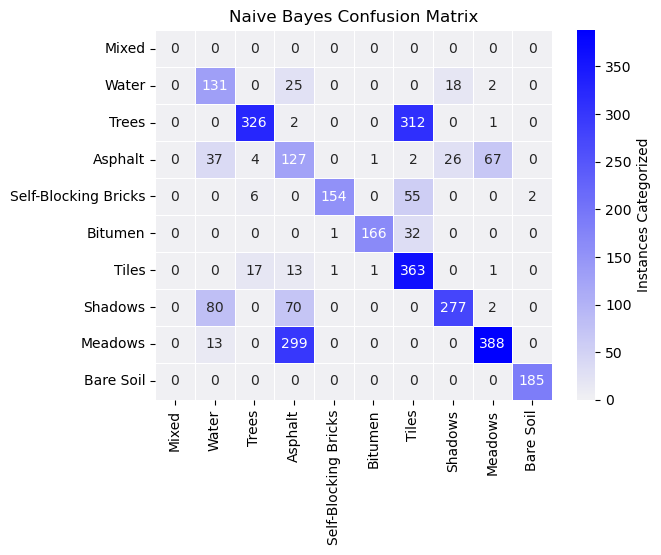

In [40]:
def conf_matrix_heatmap(name, conf_matrix):
    sns.heatmap(conf_matrix, 
                cmap=sns.color_palette("light:b", as_cmap=True),
                cbar_kws={'label': "Instances Categorized"},
                annot=True, fmt="d", linewidths=.5,
                xticklabels=class_names.values(),
                yticklabels=class_names.values())
    plt.title(name)
    plt.show()


conf_matrix_heatmap("Naive Bayes Confusion Matrix", confusion_matrix(naive_test_res, y_test))

In [41]:
def get_accuracy(predicted_labels: np.ndarray, actual_labels: np.ndarray) -> float:
    """
    Get the accuracy of the model based on its predicted and actual labels of its data.
    :param predicted_labels: the labels which the model predicted
    :param actual_labels: the actual labels of the data
    :return: a number between 0 and 1 representing the accuracy of the model
    """
    return (predicted_labels.ravel() == actual_labels.ravel()).mean()


print(f"Naive Bayes \nTraining Accuracy: {get_accuracy(naive_train_res, y_train):.3f}\nTesting Accuracy: {get_accuracy(naive_test_res, y_test):.3f}")

Naive Bayes 
Training Accuracy: 0.660
Testing Accuracy: 0.660


### Minimum Euclidean Distance

The Minimum Euclidean Distance classifier is a variant of the Bayesian Classifier, where we assume our data have the same variance across all axes, as well as each dimension being statistically independent from each other. Graphically, this would be represented as circles with equal radii, which according to the Figure containing the image classes, does not seem to be the case here.

Under this assumption, the optimal classification for a point $x$ would be the equivalent to finding the minimum euclidean distance between it and the $\mu_j \forall j$, representing the means of each class $j$.

In [42]:
from sklearn.base import BaseEstimator


class EuclideanDistanceClassifier(BaseEstimator):

    def __init__(self):
        self.means_labels = []
        self.means = []

    def fit(self, x_train, y_train):
        self.means_labels = np.unique(y_train)

        for label in self.means_labels:
            data = x_train[y_train == label]
            self.means.append(data.mean(axis=0))

        return self

    def predict(self, x):
        preds = []

        for point in x:
            distances = []

            for label in self.means_labels:
                distances.append(np.linalg.norm(point - self.means[label-1]))

            min_dist = np.argmin(distances)
            preds.append(self.means_labels[min_dist])

        return np.array(preds)

In [43]:
res = cross_val_res(EuclideanDistanceClassifier(), x_train, y_train, scoring="f1_weighted")
print(f"Minimum Euclidean Distance Mean accuracy: {res[0]:.4f}, std: {res[1]:.4f}")

Minimum Euclidean Distance Mean accuracy: 0.5966, std: 0.1240


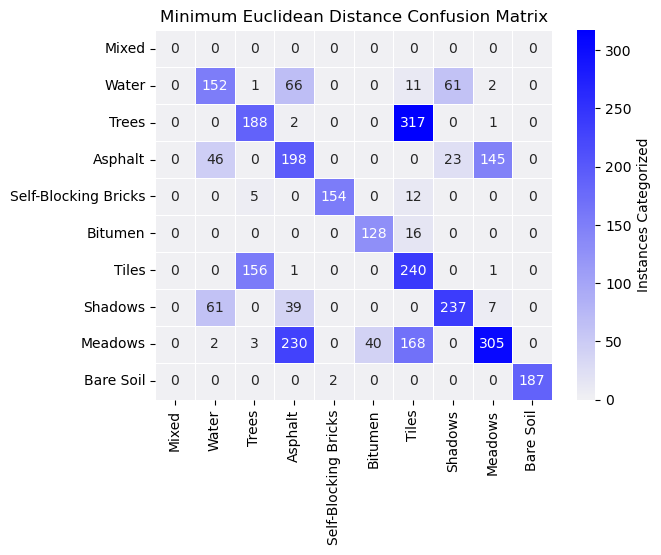

In [44]:
euclid_model = EuclideanDistanceClassifier().fit(x_train, y_train)
euclid_train_res = euclid_model.predict(x_train)
euclid_test_res = euclid_model.predict(x_test)
conf_matrix_heatmap("Minimum Euclidean Distance Confusion Matrix", confusion_matrix(euclid_test_res, y_test))

In [45]:
print(f"Minimum Euclidean Distance \nTraining Accuracy: {get_accuracy(euclid_train_res, y_train):.3f}\nTesting Accuracy: {get_accuracy(euclid_test_res, y_test):.3f}")

Minimum Euclidean Distance 
Training Accuracy: 0.568
Testing Accuracy: 0.558


### K-Nearest Neighbours

In [46]:
from sklearn.neighbors import KNeighborsClassifier


k = 5
res = cross_val_res(KNeighborsClassifier(n_neighbors=k), x_train, y_train)
print(f"{k}-NN mean accuracy {res[0]:.4f}, std: {res[1]:.4f}")

5-NN mean accuracy 0.8480, std: 0.0541


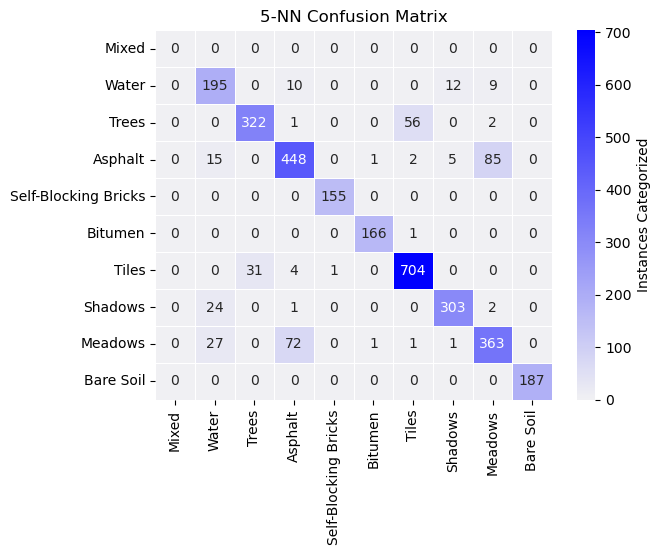

In [47]:
knn_model = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)

knn_train_res = knn_model.predict(x_train)
knn_test_res = knn_model.predict(x_test)

conf_matrix_heatmap(f"{k}-NN Confusion Matrix", confusion_matrix(knn_test_res, y_test))

In [48]:
print(f"{k}-Nearest Neighbours \nTraining Accuracy: {get_accuracy(knn_train_res, y_train):.3f}\nTesting Accuracy: {get_accuracy(knn_test_res, y_test):.3f}")

5-Nearest Neighbours 
Training Accuracy: 0.917
Testing Accuracy: 0.886


### Bayes Classifier

The general Bayes Classifier, as opposed to the Minimum Euclidean Distance Classifier, makes no assumptions in regards to the variances and covariances (statistical dependencies) between the data's dimensions, and thus is a more flexible classifier. Graphically, this can represented by curves splitting each class from the others, which according to the Figure featuring the classes, will probably be a good fit.

This classifier can be proven to be optimal in regards to the classification error. `sklearn`'s equivalent model is the QuadraticDiscriminantAnalysis estimator.

In [49]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


res = cross_val_res(QuadraticDiscriminantAnalysis(), x_train, y_train)
print(f"Bayesian mean accuracy {res[0]:.4f}, std: {res[1]:.4f}")

Bayesian mean accuracy 0.8561, std: 0.0290


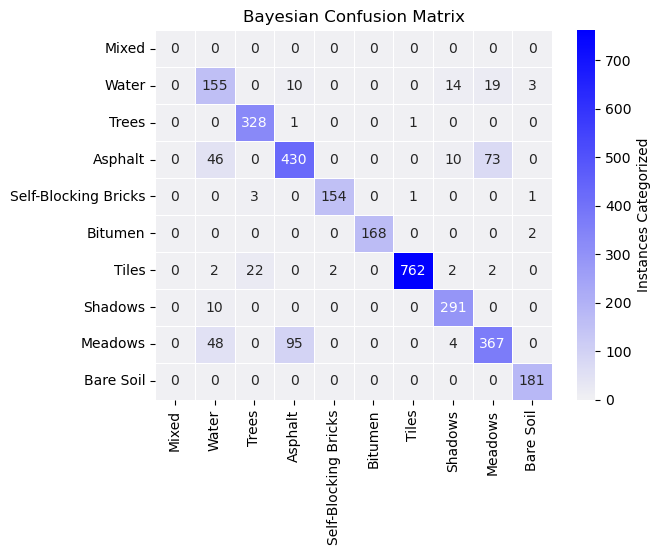

In [50]:
bayes_model = QuadraticDiscriminantAnalysis().fit(x_train, y_train)

bayes_train_res = bayes_model.predict(x_train)
bayes_test_res = bayes_model.predict(x_test)

conf_matrix_heatmap("Bayesian Confusion Matrix", confusion_matrix(bayes_test_res, y_test))

In [51]:
print(f"Bayesian Classifier \nTraining Accuracy: {get_accuracy(bayes_train_res, y_train):.3f}\nTesting Accuracy: {get_accuracy(bayes_test_res, y_test):.3f}")

Bayesian Classifier 
Training Accuracy: 0.991
Testing Accuracy: 0.884


In [52]:
print(f"Notebook executed in {time()-start:.2f} seconds")

Notebook executed in 374.27 seconds
